In [9]:
%matplotlib notebook
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import ipywidgets as widgets
from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# load data Klaas
df = pd.read_csv('../data/full_klaas.csv')
data = df[['ctrl k_on', 'ctrl k_off', 'ctrl k_syn']].values[::3]

# load data Sandberg
# df = pd.read_csv('../data/SS3_cast_UMIs_concat_params.csv')
# data = df[['k_on', 'k_off', 'k_syn']].values[::3]

# clean data
data[data == '---'] = np.nan
data = data.astype(float)
data = np.log10(data)
k_on, k_off, k_syn = data.T

# read paramater space estimation
file = open("../data/large.pkl",'rb')
vals, x_vals, y_vals, z_vals, nr_cells = pickle.load(file)

# parameters from this space
lambdas = -3, 3.01, 0.5
mus = -3, 3.01, 0.5
nus = -2, 3.51, 0.5
cells = 2, 4.01, 0.5

<IPython.core.display.Javascript object>


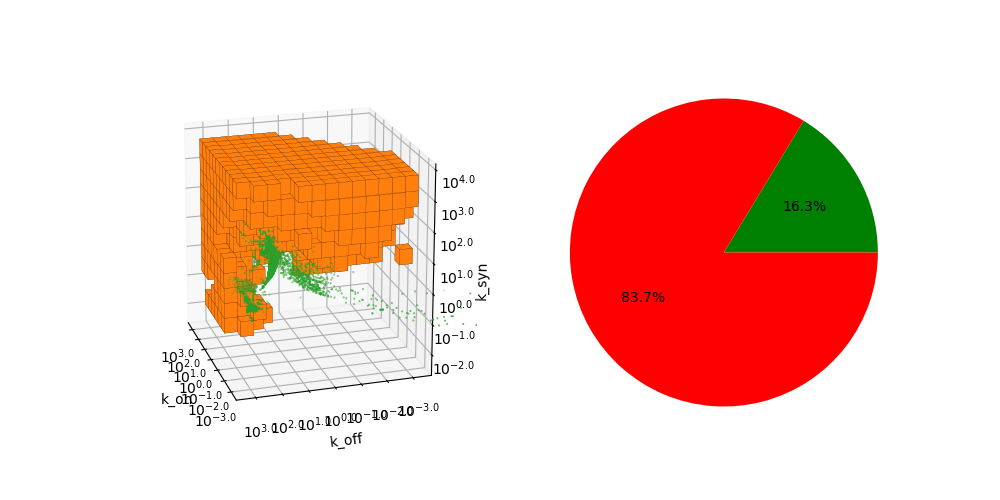

interactive(children=(FloatSlider(value=1.0, description='accuracy', max=10.0, step=0.15), Output()), _dom_cla…

interactive(children=(IntSlider(value=0, description='nr_cells', max=4), Output()), _dom_classes=('widget-inte…

In [10]:
# setup the figure
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2)
# ax1 = fig.gca(projection='3d')

cells_index = _accuracy = 1
Z = vals[..., cells_index]


def precision(accuracy):
    global ax1, ax2, vals, voxels, cells_index, _accuracy, scatters, k_on, k_off, k_syn, cells
    _accuracy = accuracy
    for coord, voxel in voxels.items():
        voxel.remove()
    
    cubes = vals[..., cells_index] < _accuracy

    x = np.clip(np.floor(rescale(lambdas, k_on)).astype(int), 0, cubes.shape[0])
    y = np.clip(np.floor(rescale(mus, k_off)).astype(int), 0, cubes.shape[1])
    z = np.clip(np.floor(rescale(nus, k_syn)).astype(int), 0, cubes.shape[2])

    falses = ~cubes[x, y, z]

    scatters.remove()
    scatters = ax1.scatter(rescale(lambdas, k_on)[falses],
                          rescale(mus, k_off)[falses], 
                          rescale(nus, k_syn)[falses], s=0.2, c='C2')

    voxels = ax1.voxels(cubes, edgecolor='k', linewidth=0.1, facecolor='C1')
    
    ax2.clear()
    total = falses.shape[0]
    trues = (1 - (np.sum(falses) / total))
    falses = 1 - trues
    ax2.pie([trues * 100, falses * 100],autopct='%1.1f%%', colors=['g', 'r'])
    fig.canvas.draw_idle()

    
def cell_count(nr_cells):
    global ax1, ax2, vals, voxels, cells_index, accuracy, scatters, k_on, k_off, k_syn, cells
    cells_index = nr_cells
    for coord, voxel in voxels.items():
        voxel.remove()

    cubes = vals[..., cells_index] < _accuracy
    print(f"The number of cells is: {int(10**np.arange(*cells)[cells_index])}")
    
    x = np.clip(np.floor(rescale(lambdas, k_on)).astype(int), 0, cubes.shape[0])
    y = np.clip(np.floor(rescale(mus, k_off)).astype(int), 0, cubes.shape[1])
    z = np.clip(np.floor(rescale(nus, k_syn)).astype(int), 0, cubes.shape[2])

    falses = ~cubes[x, y, z]

    scatters.remove()
    scatters = ax1.scatter(rescale(lambdas, k_on)[falses],
                          rescale(mus, k_off)[falses], 
                          rescale(nus, k_syn)[falses], s=0.2, c='C2')
    
    voxels = ax1.voxels(cubes, edgecolor='k', linewidth=0.1, facecolor='C1')

    ax2.clear()
    total = falses.shape[0]
    trues = (1 - (np.sum(falses) / total))
    falses = 1 - trues
    ax2.pie([trues * 100, falses * 100],autopct='%1.1f%%', colors=['g', 'r'])
    fig.canvas.draw_idle()


def rescale(val_slice, values):
    min_, stepsize = val_slice[0], val_slice[2]
    return (values - min_) / stepsize


# convert k_on k_off k_syn to correct grid
scatters = ax1.scatter(rescale(lambdas, k_on),
                      rescale(mus, k_off), 
                      rescale(nus, k_syn), s=0.2, c='C2')

voxels = ax1.voxels(vals[..., cells_index] < _accuracy, 
                   edgecolor='k', linewidth=0.1, facecolor='C1')

# create a slider
a = interact(precision, accuracy=widgets.FloatSlider(min=0,max=10,value=1, step=0.15))
a = interact(cell_count, nr_cells=widgets.IntSlider(min=0,max=vals.shape[-1] - 1,value=0))


def set_ticker(val_slice):
    def _ticker(x, pos=None):
        min_, stepsize = val_slice[0], val_slice[2]
        val = min_ + (x - 0.5) * stepsize
        return '$10^{{{}}}$'.format(val)
    return _ticker

labels = 'inside', 'outside'
sizes = [1, 99]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

ax2.axis('equal')


ax1.xaxis.set_major_formatter(ticker.FuncFormatter(set_ticker(lambdas)))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(set_ticker(mus)))
ax1.zaxis.set_major_formatter(ticker.FuncFormatter(set_ticker(nus)))

ax1.set_xticks(np.arange(lambdas[2], vals.shape[1], 2), minor=False)
ax1.set_yticks(np.arange(mus[2], vals.shape[1], 2), minor=False)
ax1.set_zticks(np.arange(nus[2], vals.shape[1], 2), minor=False)
ax1.set_xlabel('k_on'), ax1.set_ylabel('k_off'), ax1.set_zlabel('k_syn')
ax1.grid(True)
